In [88]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt

Derivation of the schemes:  
I found the exercise very unclear about this. The PDE differs from the advection case (even (GA) ). For the schemes I replaced the space part with $$H( S\lbrack u_x \rbrack ), \quad H(p) = 0.5 * p^2$$  
For S, I plugged in the scheme from the last sheet.  
In upwind I used the smallest point, since the in the upwind scheme, we always choose the point with the smallest value.
I am a bit unsure about this approach and wish, that we could discuss it in the tutorial


In [89]:
def upwind(south, southeast, southwest, delta_t, delta_x):
    """
    Calculates the upwind scheme
    Input:
        south:     v_i_j
        southwest: v_i-1_j
        southeast: v_i+1_j
    
    Output:
        v_i_{j+1}: The newly calculated point
    """
    Hamiltonian = 0
    #we should always depend on the point with the smallest value
    if(southwest <= southeast):
        Hamiltonian = 0.5 * ((south - southwest) / delta_x)**2
    else:
        Hamiltonian = 0.5 * ((southeast - south) / delta_x)**2
    
    return south - delta_t * Hamiltonian

def lax(southeast, southwest, delta_t, delta_x):
    """
    Calculates the lax-friedrich scheme
    Input:
        southeast: v_i+1_j
        southwest: v_i-1_j
    
    Output:
        v_i_{j+1}: The newly calculated point
    """
    Hamiltonian = 0.5 * ((southeast - southwest) / delta_x)**2

    return 0.5 * (southeast + southwest) - delta_t * Hamiltonian

#I took the liberty to rename to u_1 and u_2
def u_1(x):
    """
    calculate the value of u_1 at x, also takes np.arrays as arguments
    Input:
        x: point(value) or points(as np.array) where to evaluate the function
    """
    return np.maximum(1 - 16 * (x - 0.5)**2, 0)

def u_2(x):
    """
    calculate the value of u_2 at x, also takes np.arrays as arguments
    Input:
        x: point(value) or points(as np.array) where to evaluate the function
    """
    return -1 * np.maximum(1 - 16 * (x - 0.5)**2, 0)

In [90]:
#setting the hyperparameters
T = 0.05 # maximum number of the time, here the max we should plot is 150
omega_boundaries = (0,1)
delta_t = 0.01
delta_x = 0.2

In [91]:
#functions for the exact solutions
def exact_solution_u_1(x, t):
    res = 0
    if(0.25 <= x and x <= 0.75):
        res = (abs(x - 0.5) - 0.25)**2 / (2 * t)
        
    return res

def exact_solution_u_2(x, t):
    res = min(abs(x - 0.5)**2 / (2 * t + 1 / 16) - 1, 0)
    return res

In [92]:
#calculate the initial solution array which is the same for every scheme, but different for different IC

def give_initial_solution_1(delta_x, delta_t, T, omega_boundaries):

    num_points_time = int(T/delta_t)+1
    num_points_space = int((omega_boundaries[1] - omega_boundaries[0])/delta_x)+1
    sol_array = np.empty((num_points_time, num_points_space))
    sol_array[:] = np.nan

    sol_at_time_zero = u_1(np.arange(omega_boundaries[0], num_points_space)*delta_x)
    sol_at_left_border = np.array([exact_solution_u_1(omega_boundaries[0], delta_t * i) for i in range(num_points_time)])
    sol_at_right_border = np.array([exact_solution_u_1(omega_boundaries[1], delta_t * i) for i in range(num_points_time)])
    #print(sol_at_left_border, sol_at_right_border)
    sol_array[0,:] = sol_at_time_zero
    sol_array[:,0] = sol_at_left_border
    sol_array[:,-1] = sol_at_right_border
    
    return sol_array

def give_initial_solution_2(delta_x, delta_t, T, omega_boundaries):

    num_points_time = int(T/delta_t)+1
    num_points_space = int((omega_boundaries[1] - omega_boundaries[0])/delta_x)+1
    sol_array = np.empty((num_points_time, num_points_space))
    sol_array[:] = np.nan

    sol_at_time_zero = u_2(np.arange(omega_boundaries[0], num_points_space)*delta_x)
    sol_at_left_border = np.array([exact_solution_u_2(omega_boundaries[0], delta_t * i) for i in range(num_points_time)])
    sol_at_right_border = np.array([exact_solution_u_2(omega_boundaries[1], delta_t * i) for i in range(num_points_time)])
    #print(sol_at_left_border, sol_at_right_border)
    
    sol_array[0,:] = sol_at_time_zero
    sol_array[:,0] = sol_at_left_border
    sol_array[:,-1] = sol_at_right_border
    
    return sol_array

In [93]:
def calculate_exact_1(delta_x, delta_t):
    exact_sol = give_initial_solution_1(delta_x, delta_t, T, omega_boundaries)
    
    for j in range(1, exact_sol.shape[0]):
        for i in range(1, exact_sol.shape[1]-1):
            exact_sol[j][i] = exact_solution_u_1(i * delta_x, j * delta_x)
    return exact_sol

def calculate_upwind_1(delta_x, delta_t):
    upwind_sol = give_initial_solution_1(delta_x, delta_t, T, omega_boundaries)
    for j in range(1, upwind_sol.shape[0]):
        for i in range(1, upwind_sol.shape[1]-1):
            upwind_sol[j][i] = upwind(upwind_sol[j-1][i], upwind_sol[j-1][i+1], upwind_sol[j-1][i-1], delta_t, delta_x)
    return upwind_sol

def calculate_lax_1(delta_x, delta_t):
    lax_sol = give_initial_solution_1(delta_x, delta_t, T, omega_boundaries)
    for j in range(1, lax_sol.shape[0]):
        for i in range(1, lax_sol.shape[1]-1):
            lax_sol[j][i] = lax(lax_sol[j-1][i+1], lax_sol[j-1][i-1], delta_t, delta_x)
    return lax_sol


def calculate_exact_2(delta_x, delta_t):
    exact_sol = give_initial_solution_2(delta_x, delta_t, T, omega_boundaries)    
    for j in range(1, exact_sol.shape[0]):
        for i in range(1, exact_sol.shape[1]-1):
            exact_sol[j][i] = exact_solution_u_2(i * delta_x, j * delta_x)
    return exact_sol

def calculate_upwind_2(delta_x, delta_t):
    upwind_sol = give_initial_solution_2(delta_x, delta_t, T, omega_boundaries)
    for j in range(1, upwind_sol.shape[0]):
        for i in range(1, upwind_sol.shape[1]-1):
            upwind_sol[j][i] = upwind(upwind_sol[j-1][i], upwind_sol[j-1][i+1], upwind_sol[j-1][i-1], delta_t, delta_x)
    return upwind_sol

def calculate_lax_2(delta_x, delta_t):
    lax_sol = give_initial_solution_2(delta_x, delta_t, T, omega_boundaries)
    for j in range(1, lax_sol.shape[0]):
        for i in range(1, lax_sol.shape[1]-1):
            lax_sol[j][i] = lax(lax_sol[j-1][i+1], lax_sol[j-1][i-1], delta_t, delta_x)
    return lax_sol

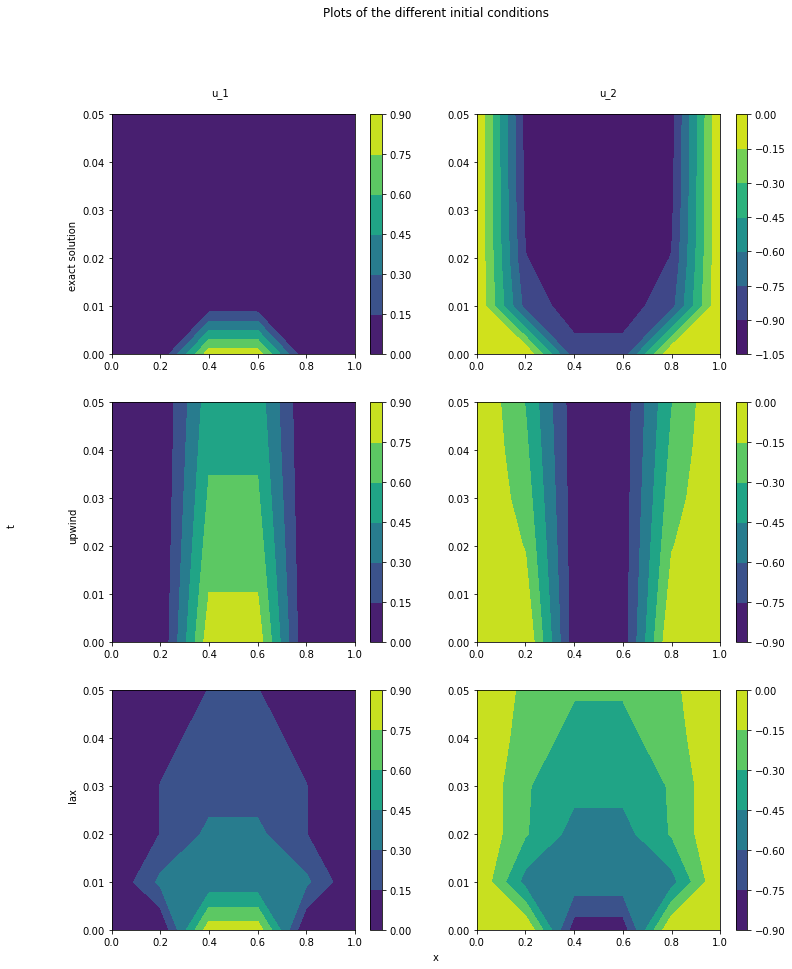

In [97]:
fig = plt.figure(figsize=(12,15))
fig.tight_layout()
tt = np.arange(0, T + delta_t, delta_t)
xx = np.arange(omega_boundaries[0], omega_boundaries[1]+delta_x, delta_x)
func_array_1 = [calculate_exact_1, calculate_upwind_1, calculate_lax_1]
func_array_2 = [calculate_exact_2, calculate_upwind_2, calculate_lax_2]

ax1 = fig.add_subplot(3, 2, 1)

res_exact_1 = func_array_1[0](delta_x, delta_t)
surf_exact_1 = ax1.contourf(xx, tt, res_exact_1)
fig.colorbar(surf_exact_1)

ax2 = fig.add_subplot(3, 2, 3)

res_upwind_1 = func_array_1[1](delta_x, delta_t)
surf_upwind_1 = ax2.contourf(xx, tt, res_upwind_1)
fig.colorbar(surf_upwind_1)

ax3 = fig.add_subplot(3, 2, 5)

res_lax_1 = func_array_1[2](delta_x, delta_t)
surf_lax_1 = ax3.contourf(xx, tt, res_lax_1)
fig.colorbar(surf_lax_1)

ax4 = fig.add_subplot(3, 2, 2)

res_exact_2 = func_array_2[0](delta_x, delta_t)
surf_exact_2 = ax4.contourf(xx, tt, res_exact_2)
fig.colorbar(surf_exact_2)

ax5 = fig.add_subplot(3, 2, 4)

res_upwind_2 = func_array_2[1](delta_x, delta_t)
surf_upwind_2 = ax5.contourf(xx, tt, res_upwind_2)
fig.colorbar(surf_upwind_2)

ax6 = fig.add_subplot(3, 2, 6)

res_lax_2 = func_array_2[2](delta_x, delta_t)
surf_lax_2 = ax6.contourf(xx, tt, res_lax_2)
fig.colorbar(surf_lax_2)

fig.suptitle('Plots of the different initial conditions')
fig.text(0.5, 0.1, 'x', ha='center', va='center')
fig.text(0.01, 0.5, 't', ha='center', va='center', rotation='vertical')
fig.text(0.08, 0.75, 'exact solution', ha='center', va='center', rotation='vertical')
fig.text(0.08, 0.5, 'upwind', ha='center', va='center', rotation='vertical')
fig.text(0.08, 0.25, 'lax', ha='center', va='center', rotation='vertical')
fig.text(0.25, 0.9, 'u_1' , ha='center', va='center')
fig.text(0.7, 0.9, 'u_2' , ha='center', va='center')

plt.show()

In [99]:
#error computation
exact_sol_1_at_T = res_exact_1[-1]
upwind_sol_1_at_T = res_upwind_1[-1]
lax_sol_1_at_T = res_lax_1[-1]

exact_sol_2_at_T = res_exact_2[-1]
upwind_sol_2_at_T = res_upwind_2[-1]
lax_sol_2_at_T = res_lax_2[-1]

print('Error for the lax-solution of u_1', LA.norm(exact_sol_1_at_T - lax_sol_1_at_T, np.inf))
print('Error for the upwind-solution of u_1', LA.norm(exact_sol_1_at_T - upwind_sol_1_at_T, np.inf))
print('')
print('Error for the lax-solution of u_2', LA.norm(exact_sol_2_at_T - lax_sol_2_at_T, np.inf))
print('Error for the upwind-solution of u_2', LA.norm(exact_sol_2_at_T - upwind_sol_2_at_T, np.inf))

Error for the lax-solution of u_1 0.14090841273758464
Error for the upwind-solution of u_1 0.522091245737437

Error for the lax-solution of u_2 0.7680321985566145
Error for the upwind-solution of u_2 0.6497048821010735


The choice of the IC greatly influences the results. (If my implementation is correct)  
Intuitively I expect higher convergence results for $u_1$ since with a positive IC the values have a posive speed and propagate outwards.  
With a negaive IC the values propagate inwards, so our IC is more like a terminal condition. However the scheme still wants to propagate it normally